In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import norm

%matplotlib inline

# I. Reading and Preprocessing Data

In [2]:
airbnb = pd.read_csv("data.csv", index_col=False)

In [3]:
pd.concat([airbnb.isnull().sum(), (airbnb.isnull().sum()/airbnb.isnull().count()).apply(lambda x: "{0:.2f}%".format(x * 100))], axis=1, keys=["Missing Value", "Missing Value (%)"])

,Missing Value,Missing Value (%)
room_id,0,0.00%
host_id,0,0.00%
room_type,9,0.05%
borough,19377,100.00%
neighborhood,0,0.00%
reviews,0,0.00%
overall_satisfaction,7216,37.24%
accommodates,0,0.00%
bedrooms,9,0.05%
price,9,0.05%


From the table we can see that the borough attribute is not useful in our analysis as it contains fully missing values. We then dig further to see other attributes containing missing values such as overall_satisfaction and minstay.

In [4]:
airbnb["price"].isnull().value_counts()

False    19368
True         9
Name: price, dtype: int64

In [5]:
airbnb = airbnb[airbnb["price"].isnull() == False]
airbnb = airbnb.drop(["room_id", "host_id", "borough", "latitude", "longitude", "last_modified"], axis=1)
airbnb.loc[airbnb["minstay"].isnull() == True, "minstay"] = 1
airbnb = airbnb.dropna()
print(airbnb.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12154 entries, 0 to 19376
Data columns (total 13 columns):
room_type                   12154 non-null object
neighborhood                12154 non-null object
reviews                     12154 non-null int64
overall_satisfaction        12154 non-null float64
accommodates                12154 non-null int64
bedrooms                    12154 non-null float64
price                       12154 non-null float64
minstay                     12154 non-null float64
train_dist                  12154 non-null float64
bus_dist                    12154 non-null float64
road_dist                   12154 non-null float64
URAPlanningRegion           12154 non-null object
AvgDistTouristAttraction    12154 non-null float64
dtypes: float64(8), int64(2), object(3)
memory usage: 1.3+ MB
None


We simply deleted the nine records which do not even have a price. Moreover, room_id, host_id, borough, latitude, longitude, last_modified will not be useful in our analysis. Finally, when dealing with the missing value in minstay, we can safely assume that those with missing value in minstay will have a minstay of at least 1 day. Hence, we set all the missing values in minstay to be 1.

In [6]:
pd.concat([airbnb.isnull().sum().sort_values(ascending=False), (airbnb.isnull().sum()/airbnb.isnull().count()).sort_values(ascending=False)], 
          axis=1, keys=["Total", "Percentage"])

,Total,Percentage
AvgDistTouristAttraction,0,0.0
URAPlanningRegion,0,0.0
road_dist,0,0.0
bus_dist,0,0.0
train_dist,0,0.0
minstay,0,0.0
price,0,0.0
bedrooms,0,0.0
accommodates,0,0.0
overall_satisfaction,0,0.0


Final check on the missing values.

In [7]:
airbnb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12154 entries, 0 to 19376
Data columns (total 13 columns):
room_type                   12154 non-null object
neighborhood                12154 non-null object
reviews                     12154 non-null int64
overall_satisfaction        12154 non-null float64
accommodates                12154 non-null int64
bedrooms                    12154 non-null float64
price                       12154 non-null float64
minstay                     12154 non-null float64
train_dist                  12154 non-null float64
bus_dist                    12154 non-null float64
road_dist                   12154 non-null float64
URAPlanningRegion           12154 non-null object
AvgDistTouristAttraction    12154 non-null float64
dtypes: float64(8), int64(2), object(3)
memory usage: 1.3+ MB


In [8]:
airbnb.head()

,room_type,neighborhood,reviews,overall_satisfaction,accommodates,bedrooms,price,minstay,train_dist,bus_dist,road_dist,URAPlanningRegion,AvgDistTouristAttraction
0,Private room,TS29,13,4.5,1,1.0,39.0,5.0,0.011387,0.000671,0.000005,Novena,0.052531
2,Entire home/apt,TS20,4,5.0,2,1.0,76.0,2.0,0.006174,0.002294,0.000765,River Valley,0.038312
3,Private room,TS15,7,5.0,1,1.0,45.0,7.0,0.003616,0.000573,0.000354,Kallang,0.044129
4,Private room,MK18,14,5.0,2,1.0,58.0,4.0,0.008916,0.003126,0.003503,Bishan,0.078870
6,Private room,TS17,4,3.5,6,1.0,103.0,1.0,0.004462,0.001469,0.000959,Kallang,0.048143


After removing all the missing values, we have this number of records and attributes left.

# II. Attribute Exploration and Feature Engineering

In [9]:
airbnb["price"].describe()

count    12154.000000
mean       104.867945
std        123.357523
min         10.000000
25%         48.000000
50%         80.000000
75%        134.000000
max       7957.000000
Name: price, dtype: float64

Skewness: 26.074995
Kurtosis: 1434.418662


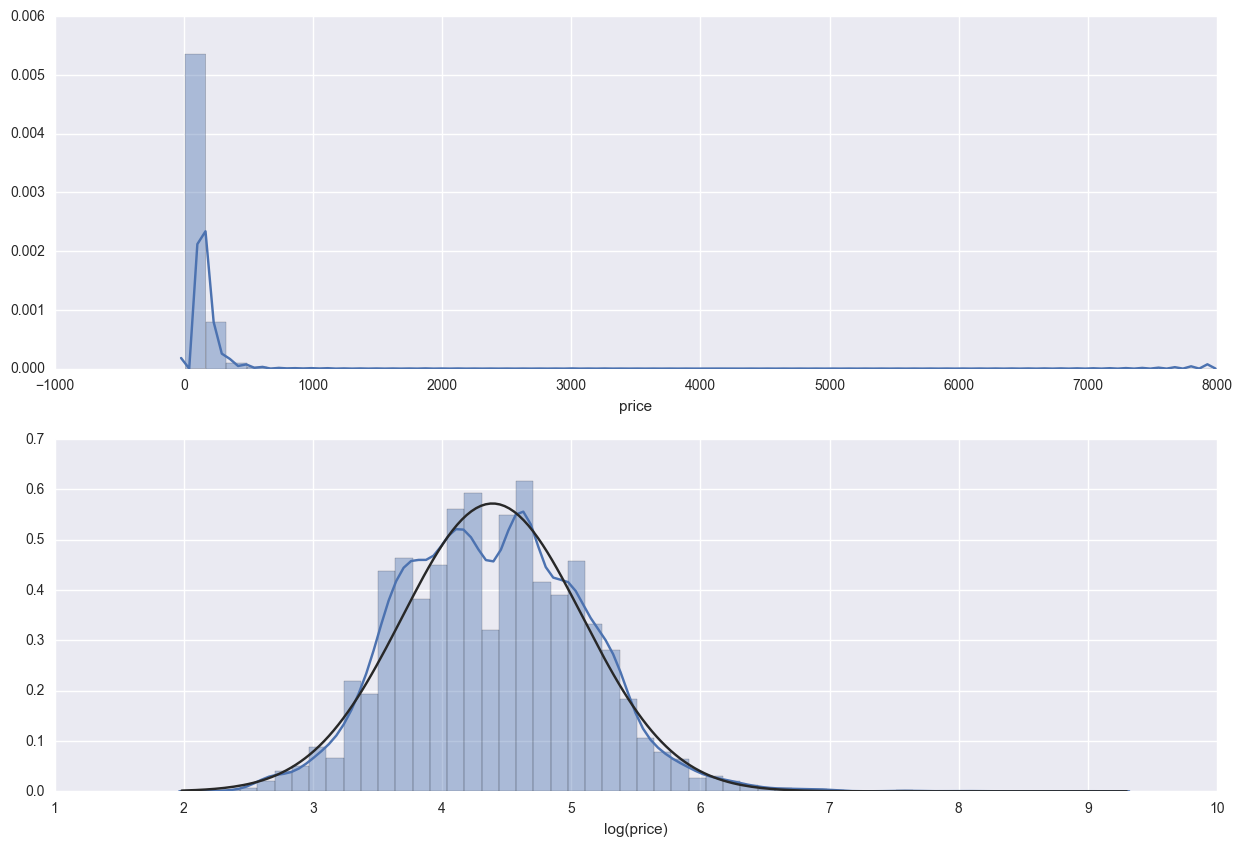

In [10]:
sns.set()
fig, ax = plt.subplots(2,1)
fig.set_size_inches(15, 10)
print("Skewness: %f" % airbnb["price"].skew())
print("Kurtosis: %f" % airbnb["price"].kurt())
sns.distplot(airbnb["price"], ax=ax[0])
sns.distplot(airbnb["price"].apply(np.log), ax=ax[1], fit=norm)
ax[1].set_xlabel("log(price)")

In [11]:
#removing outliers
airbnb = airbnb.drop([229, 12689, 8305, 16005])

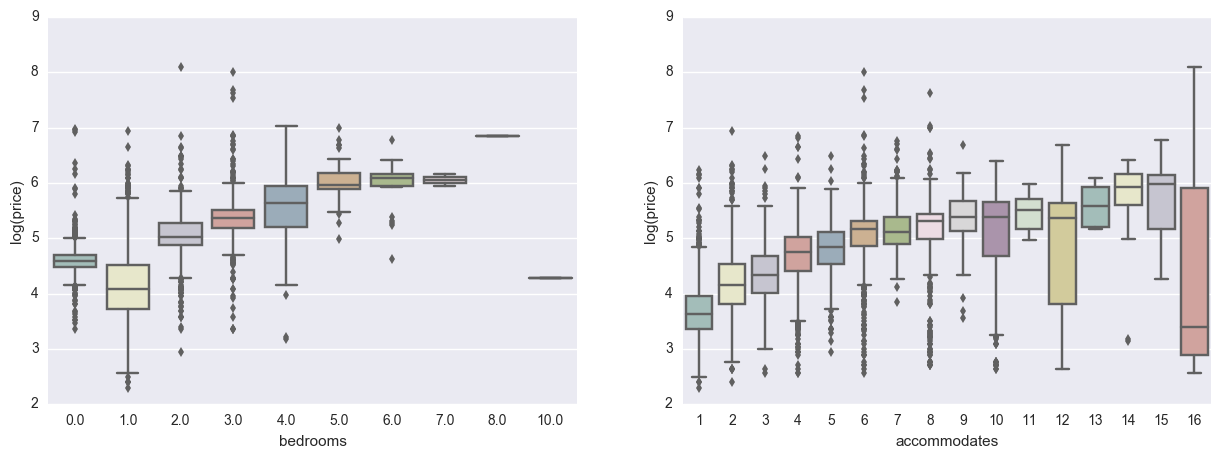

In [12]:
sns.set_palette("Set3", n_colors=16, desat=.5)
fig, ax = plt.subplots(1,2)
fig.set_size_inches(15, 5)
sns.boxplot(x="bedrooms", y=airbnb["price"].apply(np.log), data=airbnb, ax=ax[0])
sns.boxplot(x="accommodates", y=airbnb["price"].apply(np.log), data=airbnb, ax=ax[1])
ax[0].set_ylabel("log(price)")
ax[1].set_ylabel("log(price)")

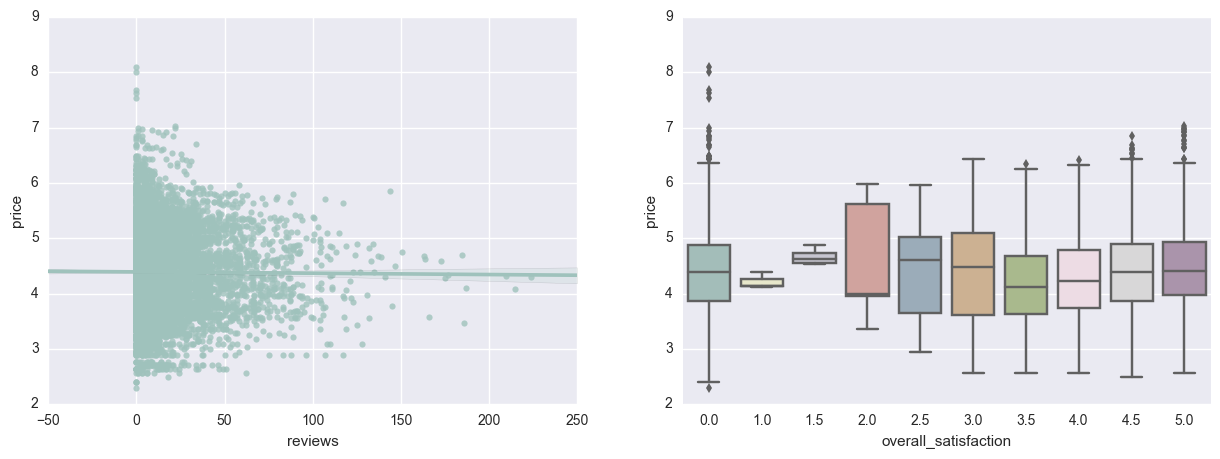

In [13]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(15, 5)
sns.regplot(x="reviews", y=airbnb["price"].apply(np.log), data=airbnb, ax=ax[0])
sns.boxplot(x="overall_satisfaction", y=airbnb["price"].apply(np.log), data=airbnb, ax=ax[1])

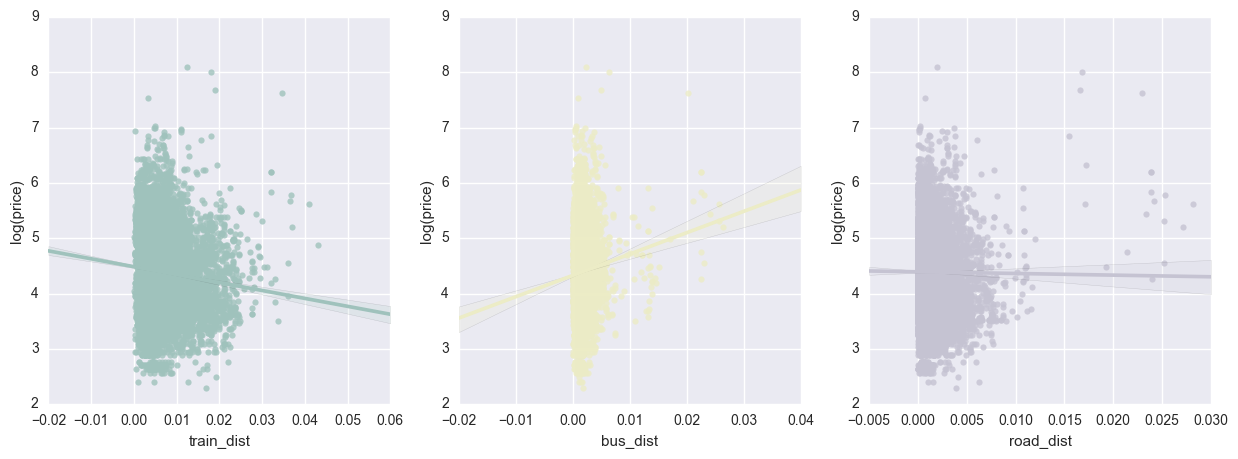

In [14]:
fig, ax = plt.subplots(1,3)
fig.set_size_inches(15, 5)
sns.regplot(x="train_dist", y=airbnb["price"].apply(np.log), data=airbnb, ax=ax[0])
sns.regplot(x="bus_dist", y=airbnb["price"].apply(np.log), data=airbnb, ax=ax[1])
sns.regplot(x="road_dist", y=airbnb["price"].apply(np.log), data=airbnb, ax=ax[2])
ax[0].set_ylabel("log(price)")
ax[1].set_ylabel("log(price)")
ax[2].set_ylabel("log(price)")

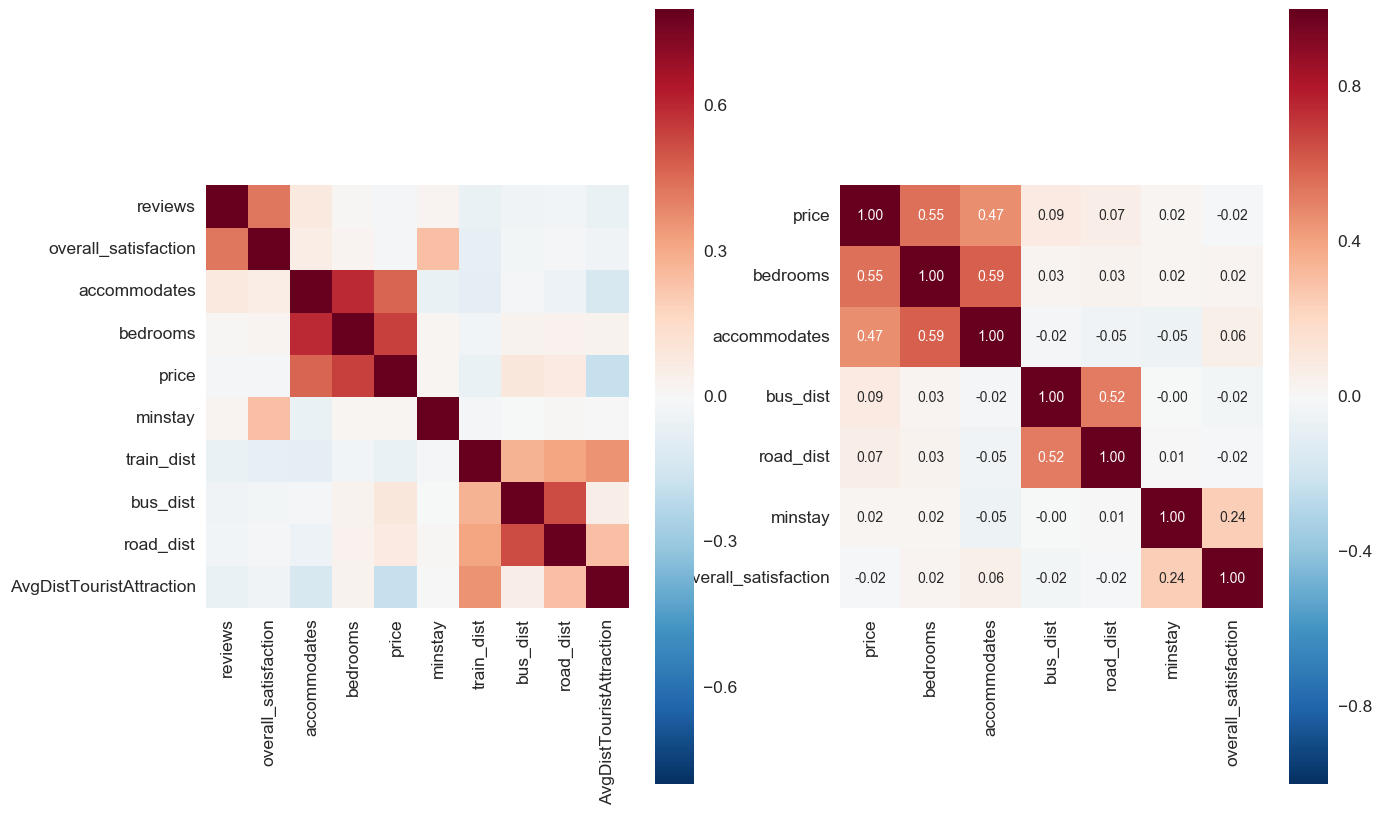

In [15]:
corr = airbnb.corr()
corr_mat = airbnb.corr()
k = 7
cols = corr_mat.nlargest(k, "price")["price"].index
cm = np.corrcoef(airbnb[cols].values.T)

sns.set(font_scale=1.25)
fig, ax = plt.subplots(1,2)
fig.set_size_inches(15, 10)
sns.heatmap(corr, vmax=.8, square=True, ax=ax[0], )
sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10},
                 yticklabels=cols.values, xticklabels=cols.values, ax=ax[1])

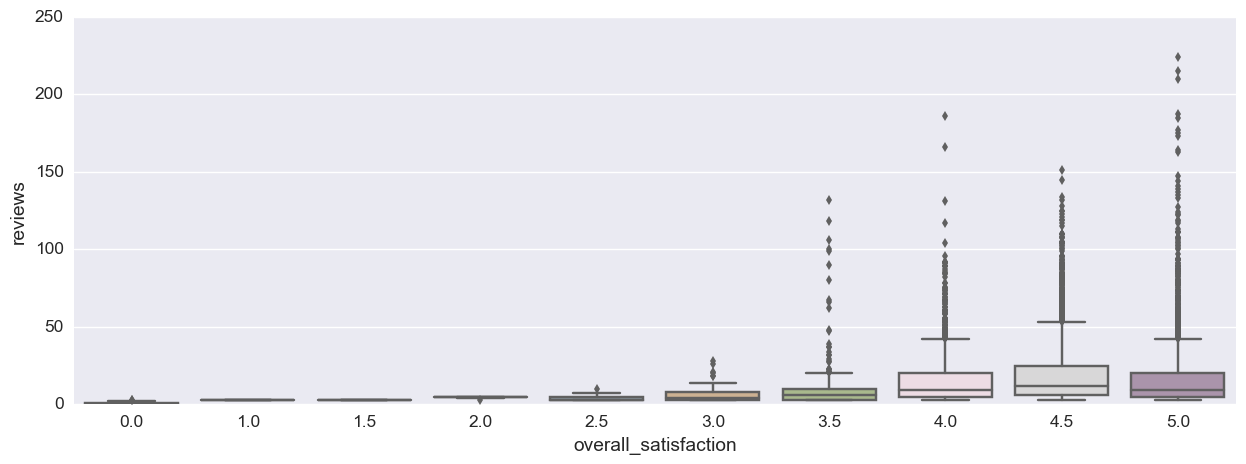

In [16]:
sns.set_palette("Set3", n_colors=16, desat=.5)
fig, ax = plt.subplots()
fig.set_size_inches(15, 5)
sns.boxplot(x="overall_satisfaction", y="reviews", data=airbnb)

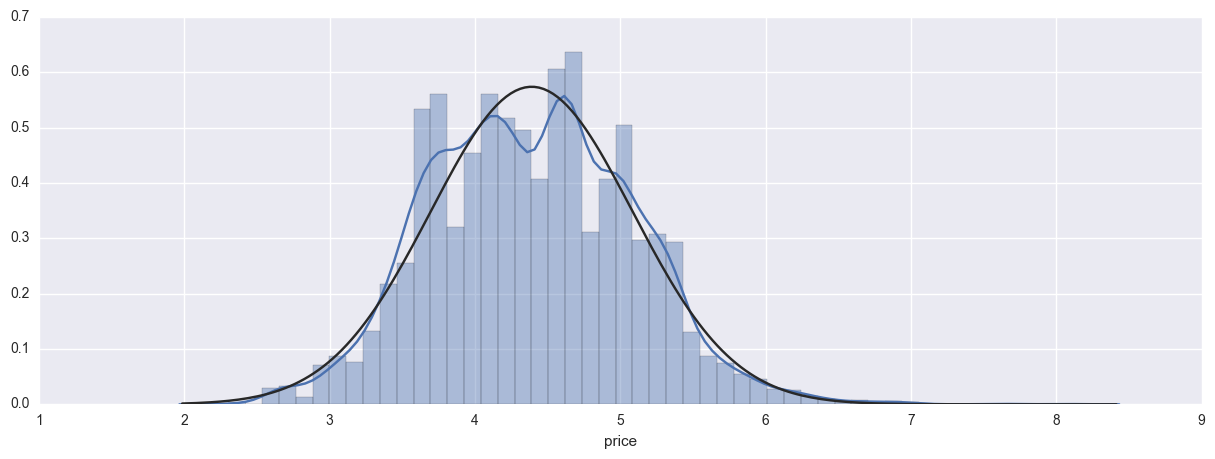

In [17]:
sns.set()
airbnb["price"] = airbnb["price"].apply(np.log)
fig, ax = plt.subplots()
fig.set_size_inches(15, 5)
sns.distplot(airbnb["price"], fit=norm)

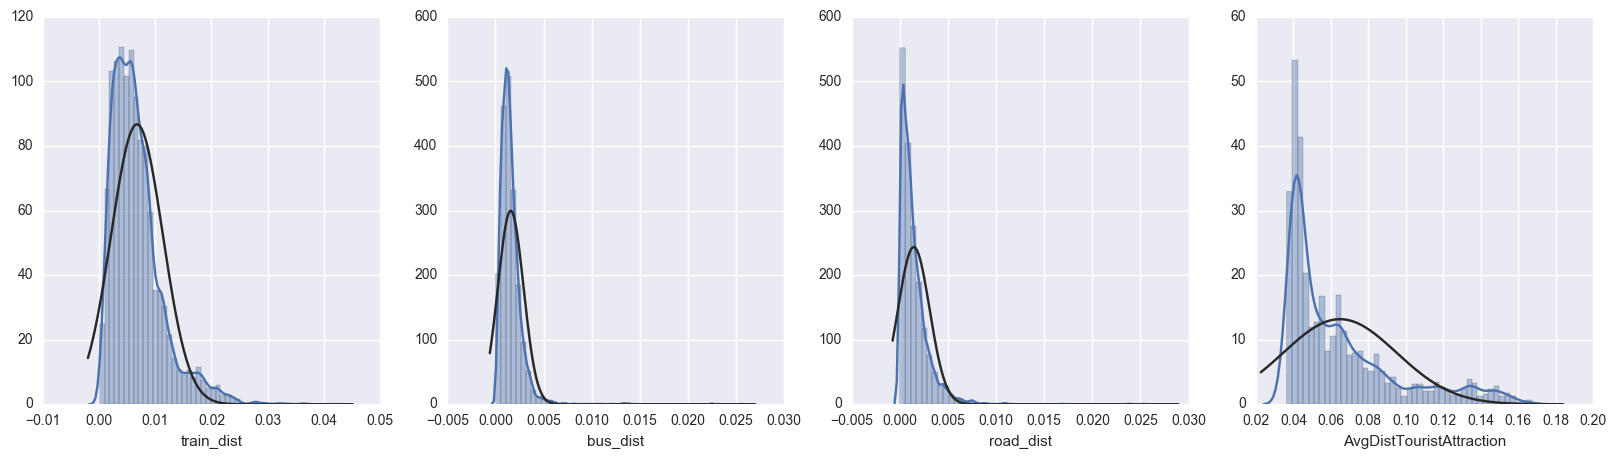

In [18]:
fig, ax = plt.subplots(1,4)
fig.set_size_inches(20, 5)
sns.distplot(airbnb["train_dist"], fit=norm, ax=ax[0])
sns.distplot(airbnb["bus_dist"], fit=norm, ax=ax[1])
sns.distplot(airbnb["road_dist"], fit=norm, ax=ax[2])
sns.distplot(airbnb["AvgDistTouristAttraction"], fit=norm, ax=ax[3])

((array([-3.85847862, -3.63596083, -3.51391714, ...,  3.51391714,
          3.63596083,  3.85847862]),
  array([ 0.03639283,  0.03643036,  0.03643036, ...,  0.16733801,
          0.16924942,  0.17030441])),
 (0.027210891156162414, 0.064834395389593069, 0.89927123001892351))

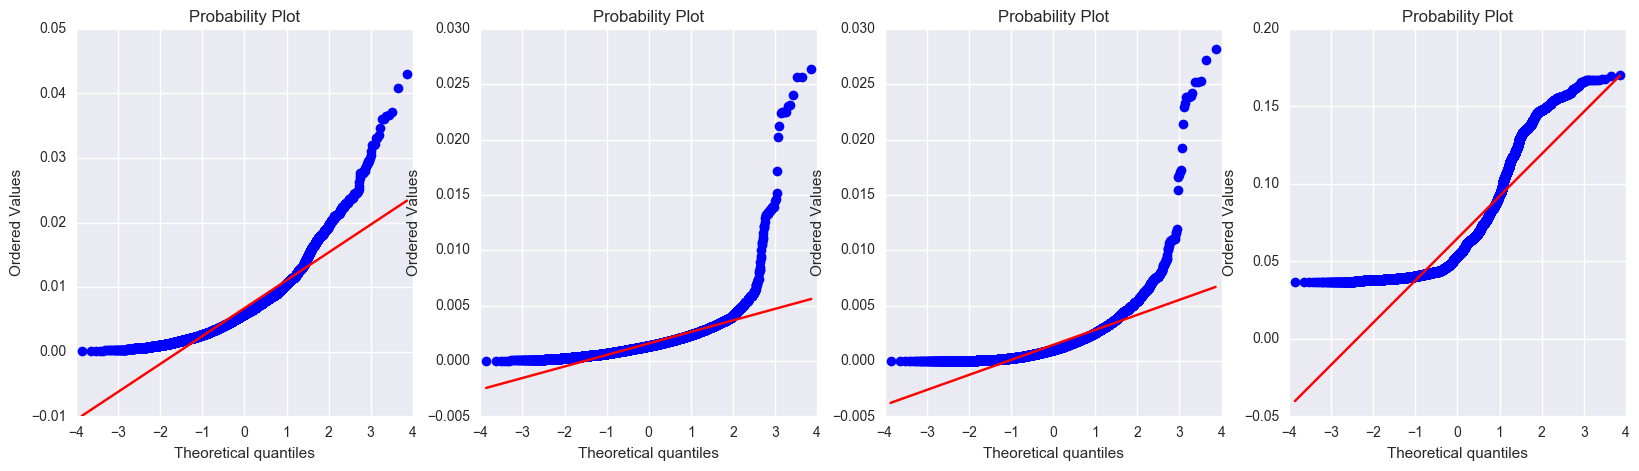

In [19]:
fig, ax = plt.subplots(1,4)
fig.set_size_inches(20, 5)
stats.probplot(airbnb["train_dist"], plot=ax[0])
stats.probplot(airbnb["bus_dist"], plot=ax[1])
stats.probplot(airbnb["road_dist"], plot=ax[2])
stats.probplot(airbnb["AvgDistTouristAttraction"], plot=ax[3])

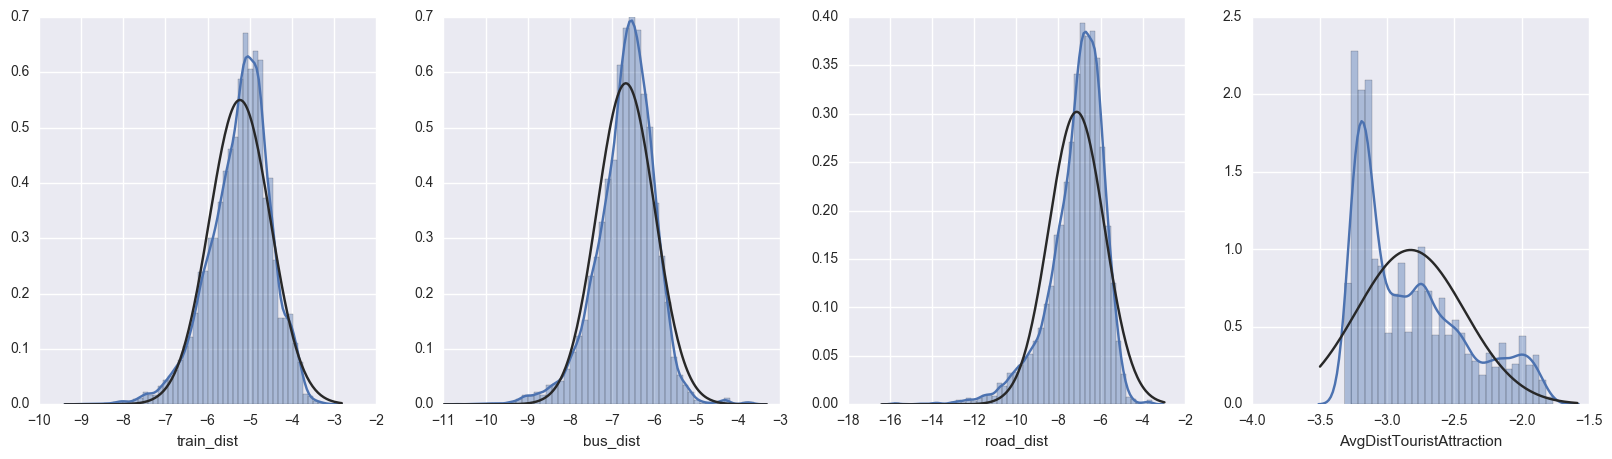

In [20]:
fig, ax = plt.subplots(1,4)
fig.set_size_inches(20, 5)
sns.distplot(airbnb["train_dist"].apply(np.log), fit=norm, ax=ax[0])
sns.distplot(airbnb["bus_dist"].apply(np.log), fit=norm, ax=ax[1])
sns.distplot(airbnb["road_dist"].apply(np.log), fit=norm, ax=ax[2])
sns.distplot(airbnb["AvgDistTouristAttraction"].apply(np.log), fit=norm, ax=ax[3])

((array([-3.85847862, -3.63596083, -3.51391714, ...,  3.51391714,
          3.63596083,  3.85847862]),
  array([-3.31338348, -3.31235288, -3.31235288, ..., -1.78773951,
         -1.77638179, -1.77016782])),
 (0.3785933882692063, -2.8241653713476191, 0.94478688084473628))

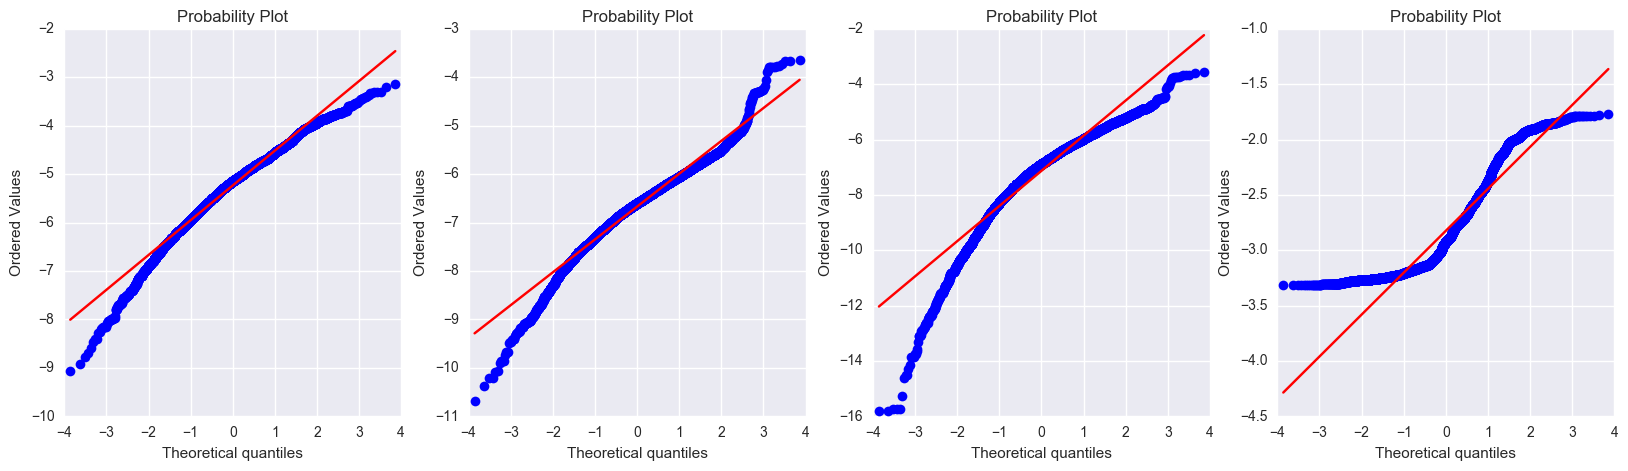

In [21]:
fig, ax = plt.subplots(1,4)
fig.set_size_inches(20, 5)
stats.probplot(airbnb["train_dist"].apply(np.log), plot=ax[0])
stats.probplot(airbnb["bus_dist"].apply(np.log), plot=ax[1])
stats.probplot(airbnb["road_dist"].apply(np.log), plot=ax[2])
stats.probplot(airbnb["AvgDistTouristAttraction"].apply(np.log), plot=ax[3])

In [22]:
airbnb["train_dist"] = airbnb["train_dist"].apply(np.log)
airbnb["road_dist"] = airbnb["road_dist"].apply(np.log)
airbnb["bus_dist"] = airbnb["bus_dist"].apply(np.log)
airbnb["AvgDistTouristAttraction"] = airbnb["AvgDistTouristAttraction"].apply(np.log)

In [23]:
airbnb.head()

,room_type,neighborhood,reviews,overall_satisfaction,accommodates,bedrooms,price,minstay,train_dist,bus_dist,road_dist,URAPlanningRegion,AvgDistTouristAttraction
0,Private room,TS29,13,4.5,1,1.0,3.663562,5.0,-4.475283,-7.306198,-12.131445,Novena,-2.946360
2,Entire home/apt,TS20,4,5.0,2,1.0,4.330733,2.0,-5.087392,-6.077253,-7.175243,River Valley,-3.261998
3,Private room,TS15,7,5.0,1,1.0,3.806662,7.0,-5.622387,-7.464947,-7.946521,Kallang,-3.120633
4,Private room,MK18,14,5.0,2,1.0,4.060443,4.0,-4.719908,-5.768144,-5.654223,Bishan,-2.539959
6,Private room,TS17,4,3.5,6,1.0,4.634729,1.0,-5.412225,-6.523454,-6.949908,Kallang,-3.033574


In [24]:
airbnb_X = airbnb
airbnb_y = airbnb["price"]

In [25]:
region_price_mean = airbnb_X.groupby("URAPlanningRegion").mean()["price"]
region_price_mean_25_percentile =  region_price_mean.describe()["25%"]
region_price_mean_75_percentile =  region_price_mean.describe()["75%"]
low = region_price_mean.loc[region_price_mean <= region_price_mean_25_percentile].index
medium = region_price_mean.loc[(region_price_mean > region_price_mean_25_percentile) & (region_price_mean <= region_price_mean_75_percentile)].index
high = region_price_mean.loc[region_price_mean > region_price_mean_75_percentile].index

In [26]:
airbnb_X.loc[airbnb_X["URAPlanningRegion"].apply(lambda x: x in low) == True, "region_price"] = "Low Price URAPlanningRegion"
airbnb_X.loc[airbnb_X["URAPlanningRegion"].apply(lambda x: x in medium) == True, "region_price"] = "Medium Price URAPlanningRegion"
airbnb_X.loc[airbnb_X["URAPlanningRegion"].apply(lambda x: x in high) == True, "region_price"] = "High Price URAPlanningRegion"
airbnb_X = airbnb_X.drop("URAPlanningRegion", axis=1)

In [27]:
neighborhood_price_mean = airbnb_X.groupby("neighborhood").mean()["price"]
neighborhood_price_mean_25_percentile =  neighborhood_price_mean.describe()["25%"]
neighborhood_price_mean_75_percentile =  neighborhood_price_mean.describe()["75%"]
low = neighborhood_price_mean.loc[neighborhood_price_mean <= neighborhood_price_mean_25_percentile].index
medium = neighborhood_price_mean.loc[(neighborhood_price_mean > neighborhood_price_mean_25_percentile) & (neighborhood_price_mean <= neighborhood_price_mean_75_percentile)].index
high = neighborhood_price_mean.loc[neighborhood_price_mean > neighborhood_price_mean_75_percentile].index

In [28]:
airbnb_X.loc[airbnb_X["neighborhood"].apply(lambda x: x in low) == True, "neighborhood_price"] = "Low Price Neighborhood"
airbnb_X.loc[airbnb_X["neighborhood"].apply(lambda x: x in medium) == True, "neighborhood_price"] = "Medium Price Neighborhood"
airbnb_X.loc[airbnb_X["neighborhood"].apply(lambda x: x in high) == True, "neighborhood_price"] = "High Price Neighborhood"
airbnb_X = airbnb_X.drop("neighborhood", axis=1)

In [29]:
# airbnb_X["transportation_convenience"] = -(0.38 * airbnb_X["train_dist"] + 0.33 * airbnb_X["bus_dist"] + 0.29 * airbnb_X["road_dist"])
# airbnb_X = airbnb_X.drop(["train_dist", "bus_dist", "road_dist"], axis=1)

In [30]:
airbnb_X.head()

,room_type,reviews,overall_satisfaction,accommodates,bedrooms,price,minstay,train_dist,bus_dist,road_dist,AvgDistTouristAttraction,region_price,neighborhood_price
0,Private room,13,4.5,1,1.0,3.663562,5.0,-4.475283,-7.306198,-12.131445,-2.946360,High Price URAPlanningRegion,High Price Neighborhood
2,Entire home/apt,4,5.0,2,1.0,4.330733,2.0,-5.087392,-6.077253,-7.175243,-3.261998,High Price URAPlanningRegion,High Price Neighborhood
3,Private room,7,5.0,1,1.0,3.806662,7.0,-5.622387,-7.464947,-7.946521,-3.120633,Medium Price URAPlanningRegion,Medium Price Neighborhood
4,Private room,14,5.0,2,1.0,4.060443,4.0,-4.719908,-5.768144,-5.654223,-2.539959,Medium Price URAPlanningRegion,Medium Price Neighborhood
6,Private room,4,3.5,6,1.0,4.634729,1.0,-5.412225,-6.523454,-6.949908,-3.033574,Medium Price URAPlanningRegion,Low Price Neighborhood


#  III. Model Building

## i. Linear Regression (Log Distance and Log Price)

In [31]:
airbnb_X = airbnb_X.join(pd.get_dummies(airbnb_X["room_type"]).iloc[:, :2].join(pd.get_dummies(airbnb_X["neighborhood_price"]).iloc[:, :2]))
airbnb_X = airbnb_X.join(pd.get_dummies(airbnb_X["region_price"]).iloc[:, :2])
airbnb_X = airbnb_X.drop(["room_type", "neighborhood_price", "region_price"], axis=1)

In [32]:
airbnb_X = airbnb_X.drop("price", axis=1)

In [33]:
airbnb_X.head()

,reviews,overall_satisfaction,accommodates,bedrooms,minstay,train_dist,bus_dist,road_dist,AvgDistTouristAttraction,Entire home/apt,Private room,High Price Neighborhood,Low Price Neighborhood,High Price URAPlanningRegion,Low Price URAPlanningRegion
0,13,4.5,1,1.0,5.0,-4.475283,-7.306198,-12.131445,-2.946360,0.0,1.0,1.0,0.0,1.0,0.0
2,4,5.0,2,1.0,2.0,-5.087392,-6.077253,-7.175243,-3.261998,1.0,0.0,1.0,0.0,1.0,0.0
3,7,5.0,1,1.0,7.0,-5.622387,-7.464947,-7.946521,-3.120633,0.0,1.0,0.0,0.0,0.0,0.0
4,14,5.0,2,1.0,4.0,-4.719908,-5.768144,-5.654223,-2.539959,0.0,1.0,0.0,0.0,0.0,0.0
6,4,3.5,6,1.0,1.0,-5.412225,-6.523454,-6.949908,-3.033574,0.0,1.0,0.0,1.0,0.0,0.0


In [34]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import xgboost as xgb
X_train, X_test, y_train, y_test = train_test_split(airbnb_X, airbnb_y, test_size=0.33)
print(X_train.shape)
print(X_test.shape)

(8140, 15)
(4010, 15)


In [35]:
model = xgb.XGBRegressor(learning_rate=0.36).fit(X_train, y_train)
y_pred = model.predict(X_test)

In [36]:
xgb_model = xgb.XGBRegressor(learning_rate=0.36)
scores = cross_val_score(xgb_model, airbnb_X, airbnb_y, cv=20, scoring='neg_mean_squared_error', n_jobs=3)
print("RMSE for Xgboost: %0.5f" % np.sqrt(-scores.mean()))

RMSE for Xgboost: 0.36457


In [37]:
pd.Series(model.feature_importances_, index=airbnb_X.columns).sort_values(ascending=False)

AvgDistTouristAttraction        0.272036
train_dist                      0.170213
bus_dist                        0.139818
road_dist                       0.107903
accommodates                    0.079027
reviews                         0.066869
bedrooms                        0.044073
overall_satisfaction            0.030395
Entire home/apt                 0.022796
Private room                    0.018237
High Price Neighborhood         0.015198
minstay                         0.012158
High Price URAPlanningRegion    0.009119
Low Price Neighborhood          0.007599
Low Price URAPlanningRegion     0.004559
dtype: float32

In [38]:
pd.concat([pd.Series(model.predict(X_test), index=X_test.index), y_test], axis=1, keys=["pred_price", "actual_price"]).apply(lambda x: np.e**x).head(20)

,pred_price,actual_price
14810,120.375313,109.0
8086,120.172920,149.0
18566,35.655273,34.0
15607,107.897560,95.0
18946,46.917500,36.0
18101,50.632736,57.0
13104,400.721405,511.0
10867,59.257248,37.0
2387,148.028717,183.0
9141,84.678253,90.0


In [39]:
airbnb_new = airbnb_X.join(airbnb_y)
airbnb_new.head()

,reviews,overall_satisfaction,accommodates,bedrooms,minstay,train_dist,bus_dist,road_dist,AvgDistTouristAttraction,Entire home/apt,Private room,High Price Neighborhood,Low Price Neighborhood,High Price URAPlanningRegion,Low Price URAPlanningRegion,price
0,13,4.5,1,1.0,5.0,-4.475283,-7.306198,-12.131445,-2.946360,0.0,1.0,1.0,0.0,1.0,0.0,3.663562
2,4,5.0,2,1.0,2.0,-5.087392,-6.077253,-7.175243,-3.261998,1.0,0.0,1.0,0.0,1.0,0.0,4.330733
3,7,5.0,1,1.0,7.0,-5.622387,-7.464947,-7.946521,-3.120633,0.0,1.0,0.0,0.0,0.0,0.0,3.806662
4,14,5.0,2,1.0,4.0,-4.719908,-5.768144,-5.654223,-2.539959,0.0,1.0,0.0,0.0,0.0,0.0,4.060443
6,4,3.5,6,1.0,1.0,-5.412225,-6.523454,-6.949908,-3.033574,0.0,1.0,0.0,1.0,0.0,0.0,4.634729


In [40]:
import statsmodels.api as sm
new_model = sm.OLS(airbnb_y, sm.add_constant(airbnb_X))
results = new_model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.697
Model:                            OLS   Adj. R-squared:                  0.697
Method:                 Least Squares   F-statistic:                     1865.
Date:                Sun, 16 Apr 2017   Prob (F-statistic):               0.00
Time:                        22:12:34   Log-Likelihood:                -5564.0
No. Observations:               12150   AIC:                         1.116e+04
Df Residuals:                   12134   BIC:                         1.128e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            2.5199      0.054     46.662      0.000       2.414       2.626
reviews                         -0.0005      0.000     -2.328      0.020      -0.001   -7.74e-05
overall_satisfaction            -0.0129      0.002     -6.825      0.000      -0.017      -0.009
accommodates                     0.0352      0.002     19.793      0.000       0.032       0.039
bedrooms                         0.2292      0.006     41.613      0.000       0.218       0.240
minstay                          0.0022      0.002      0.912      0.362      -0.003       0.007
train_dist                      -0.0566      0.005    -10.536      0.000      -0.067      -0.046
bus_dist                         0.0226      0.005      4.178      0.000       0.012       0.033
road_dist                        0.0222      0.003      7.814      0.000       0.017       0.028
AvgDistTouristAttraction        -0.1382      0.014     -9.867      0.000      -0.166      -0.111
Entire home/apt                  1.4498      0.019     76.439      0.000       1.413       1.487
Private room                     0.7895      0.019     41.040      0.000       0.752       0.827
High Price Neighborhood          0.0723      0.010      7.418      0.000       0.053       0.091
Low Price Neighborhood          -0.0448      0.013     -3.440      0.001      -0.070      -0.019
High Price URAPlanningRegion     0.1268      0.011     11.841      0.000       0.106       0.148
Low Price URAPlanningRegion     -0.0274      0.019     -1.469      0.142      -0.064       0.009
==============================================================================
Omnibus:                     2452.942   Durbin-Watson:                   0.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12239.257
Skew:                           0.890   Prob(JB):                         0.00
Kurtosis:                       7.583   Cond. No.                         382.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## ii. Renaming Columns and Correlation Matrix

In [41]:
airbnb_X_new = airbnb_X.copy()

In [42]:
airbnb_X_new.head()

,reviews,overall_satisfaction,accommodates,bedrooms,minstay,train_dist,bus_dist,road_dist,AvgDistTouristAttraction,Entire home/apt,Private room,High Price Neighborhood,Low Price Neighborhood,High Price URAPlanningRegion,Low Price URAPlanningRegion
0,13,4.5,1,1.0,5.0,-4.475283,-7.306198,-12.131445,-2.946360,0.0,1.0,1.0,0.0,1.0,0.0
2,4,5.0,2,1.0,2.0,-5.087392,-6.077253,-7.175243,-3.261998,1.0,0.0,1.0,0.0,1.0,0.0
3,7,5.0,1,1.0,7.0,-5.622387,-7.464947,-7.946521,-3.120633,0.0,1.0,0.0,0.0,0.0,0.0
4,14,5.0,2,1.0,4.0,-4.719908,-5.768144,-5.654223,-2.539959,0.0,1.0,0.0,0.0,0.0,0.0
6,4,3.5,6,1.0,1.0,-5.412225,-6.523454,-6.949908,-3.033574,0.0,1.0,0.0,1.0,0.0,0.0


In [43]:
airbnb_final = airbnb_X_new.join(airbnb_y)
airbnb_final.columns = ['reviews', 'overall_satisfaction', 'accommodates', 'bedrooms', 'minstay', 'log(train_dist)', 'log(bus_dist)', 'log(road_dist)', 'log(AvgDistTouristAttraction)','Entire home/apt', 'Private room', 'High Price Neighborhood', 'Low Price Neighborhood', 'High Price URAPlanningRegion', 'Low Price URAPlanningRegion', 'log(price)']
airbnb_final_X = airbnb_final.drop('log(price)', axis=1)
airbnb_final_y = airbnb_final['log(price)']

In [44]:
airbnb_final.head()

,reviews,overall_satisfaction,accommodates,bedrooms,minstay,log(train_dist),log(bus_dist),log(road_dist),log(AvgDistTouristAttraction),Entire home/apt,Private room,High Price Neighborhood,Low Price Neighborhood,High Price URAPlanningRegion,Low Price URAPlanningRegion,log(price)
0,13,4.5,1,1.0,5.0,-4.475283,-7.306198,-12.131445,-2.946360,0.0,1.0,1.0,0.0,1.0,0.0,3.663562
2,4,5.0,2,1.0,2.0,-5.087392,-6.077253,-7.175243,-3.261998,1.0,0.0,1.0,0.0,1.0,0.0,4.330733
3,7,5.0,1,1.0,7.0,-5.622387,-7.464947,-7.946521,-3.120633,0.0,1.0,0.0,0.0,0.0,0.0,3.806662
4,14,5.0,2,1.0,4.0,-4.719908,-5.768144,-5.654223,-2.539959,0.0,1.0,0.0,0.0,0.0,0.0,4.060443
6,4,3.5,6,1.0,1.0,-5.412225,-6.523454,-6.949908,-3.033574,0.0,1.0,0.0,1.0,0.0,0.0,4.634729


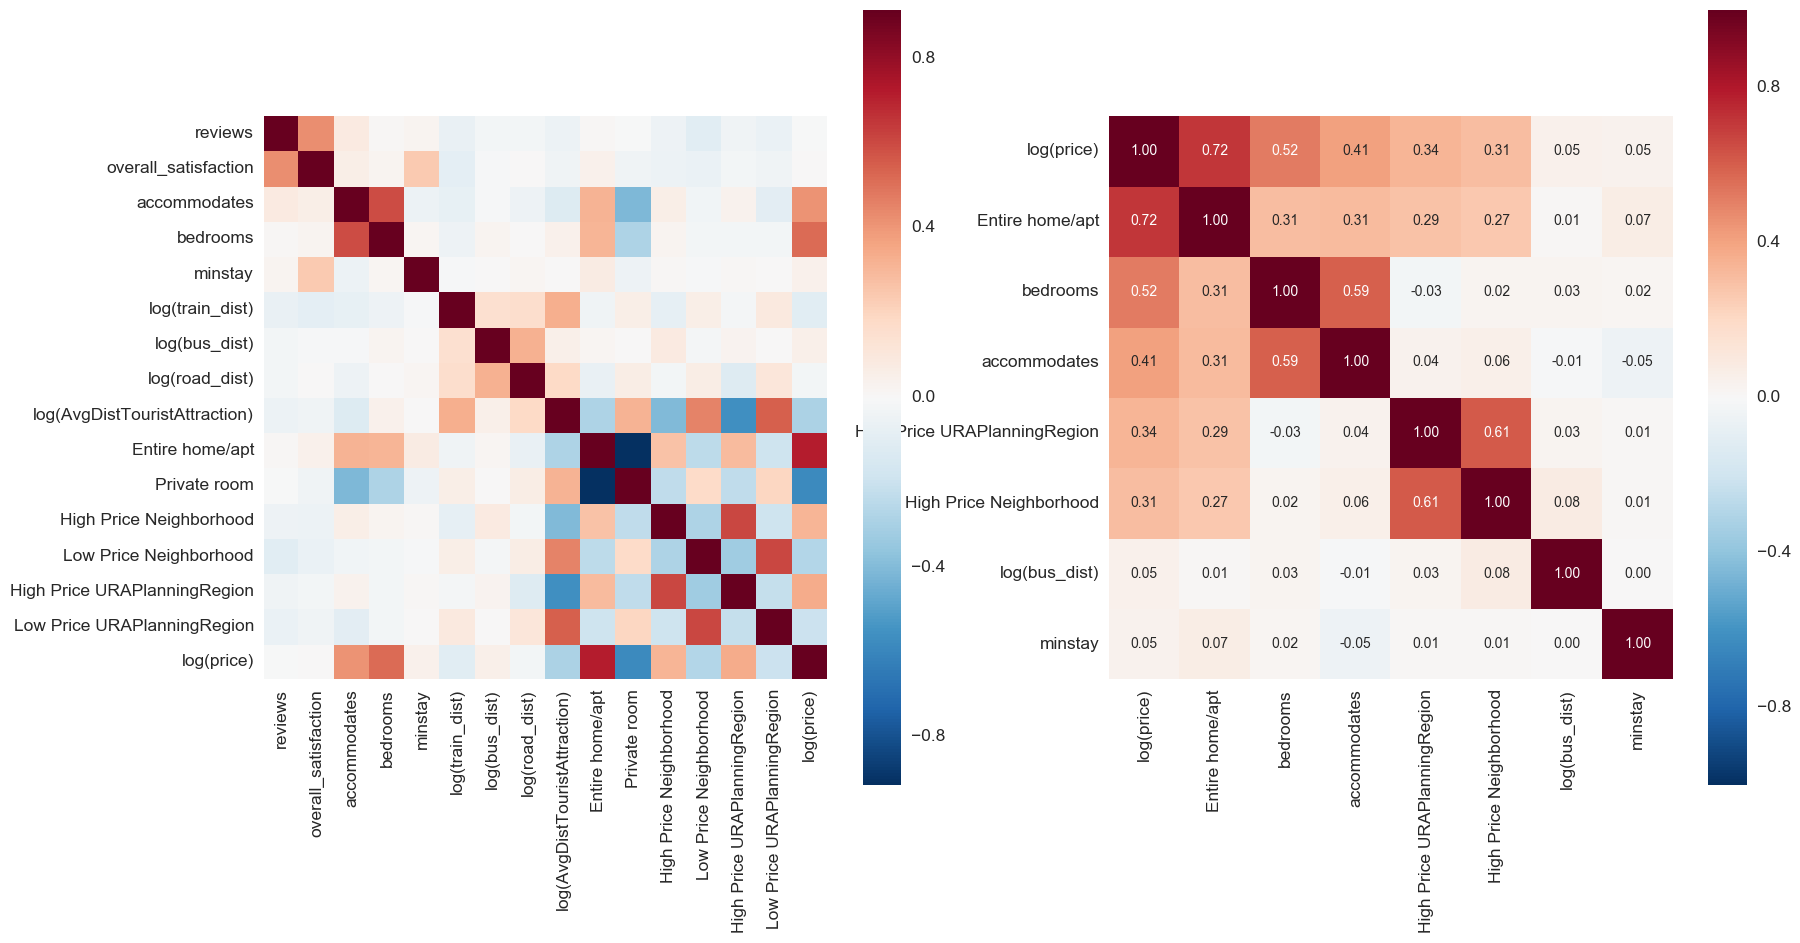

In [45]:
corr_final = airbnb_final.corr()
corr_mat_final = airbnb_final.corr()
k = 8
cols_final = corr_mat_final.nlargest(k, "log(price)")["log(price)"].index
cm_final = np.corrcoef(airbnb_final[cols_final].values.T)

sns.set(font_scale=1.25)
fig, ax = plt.subplots(1,2)
fig.set_size_inches(20, 10)
sns.heatmap(corr_final, vmax=.8, square=True, ax=ax[0])
sns.heatmap(cm_final, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10},
                 yticklabels=cols_final.values, xticklabels=cols_final.values, ax=ax[1])

# iii. Linear Regression (Removing Insignificant Attributes)

In [46]:
new_model = sm.OLS(airbnb_final_y, sm.add_constant(airbnb_final_X.drop(["minstay", "Low Price URAPlanningRegion"], axis=1)))
results = new_model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log(price)   R-squared:                       0.697
Model:                            OLS   Adj. R-squared:                  0.697
Method:                 Least Squares   F-statistic:                     2151.
Date:                Sun, 16 Apr 2017   Prob (F-statistic):               0.00
Time:                        22:12:36   Log-Likelihood:                -5565.5
No. Observations:               12150   AIC:                         1.116e+04
Df Residuals:                   12136   BIC:                         1.126e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             2.5048      0.053     47.625      0.000       2.402       2.608
reviews                          -0.0005      0.000     -2.439      0.015      -0.001      -0.000
overall_satisfaction             -0.0124      0.002     -6.823      0.000      -0.016      -0.009
accommodates                      0.0351      0.002     19.813      0.000       0.032       0.039
bedrooms                          0.2296      0.005     41.746      0.000       0.219       0.240
log(train_dist)                  -0.0556      0.005    -10.433      0.000      -0.066      -0.045
log(bus_dist)                     0.0227      0.005      4.207      0.000       0.012       0.033
log(road_dist)                    0.0221      0.003      7.767      0.000       0.017       0.028
log(AvgDistTouristAttraction)    -0.1464      0.013    -11.430      0.000      -0.171      -0.121
Entire home/apt                   1.4493      0.019     76.529      0.000       1.412       1.486
Private room                      0.7885      0.019     41.017      0.000       0.751       0.826
High Price Neighborhood           0.0723      0.010      7.411      0.000       0.053       0.091
Low Price Neighborhood           -0.0542      0.011     -4.798      0.000      -0.076      -0.032
High Price URAPlanningRegion      0.1240      0.011     11.767      0.000       0.103       0.145
==============================================================================
Omnibus:                     2447.192   Durbin-Watson:                   0.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12161.643
Skew:                           0.889   Prob(JB):                         0.00
Kurtosis:                       7.567   Cond. No.                         372.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [47]:
X_train, X_test, y_train, y_test = train_test_split(airbnb_final_X.drop(["reviews", "minstay"], axis=1), airbnb_final_y, test_size=0.33)
model = xgb.XGBRegressor(learning_rate=0.36).fit(X_train, y_train)
y_pred = model.predict(X_test)

In [48]:
from sklearn.metrics import mean_squared_error
print("RMSE for Xgboost: %0.5f" % np.sqrt(mean_squared_error(y_pred, y_test)))

RMSE for Xgboost: 0.33869


In [49]:
pd.Series(model.feature_importances_, index=airbnb_final_X.drop(["reviews", "minstay"], axis=1).columns).sort_values(ascending=False)

log(AvgDistTouristAttraction)    0.250000
log(bus_dist)                    0.155120
log(road_dist)                   0.147590
log(train_dist)                  0.147590
accommodates                     0.094880
overall_satisfaction             0.073795
bedrooms                         0.039157
Entire home/apt                  0.031627
Private room                     0.022590
High Price URAPlanningRegion     0.012048
Low Price Neighborhood           0.010542
High Price Neighborhood          0.010542
Low Price URAPlanningRegion      0.004518
dtype: float32

In [50]:
pd.concat([pd.Series(model.predict(X_test), index=X_test.index), y_test], axis=1, keys=["pred_price", "actual_price"]).apply(lambda x: np.e**x).head(20)

,pred_price,actual_price
16317,80.532455,124.0
13028,33.606602,21.0
2781,159.701416,152.0
14336,99.701889,104.0
16134,115.076019,70.0
18284,79.147629,31.0
14443,125.625916,168.0
9952,45.311684,52.0
3231,97.276779,102.0
17249,47.273685,46.0


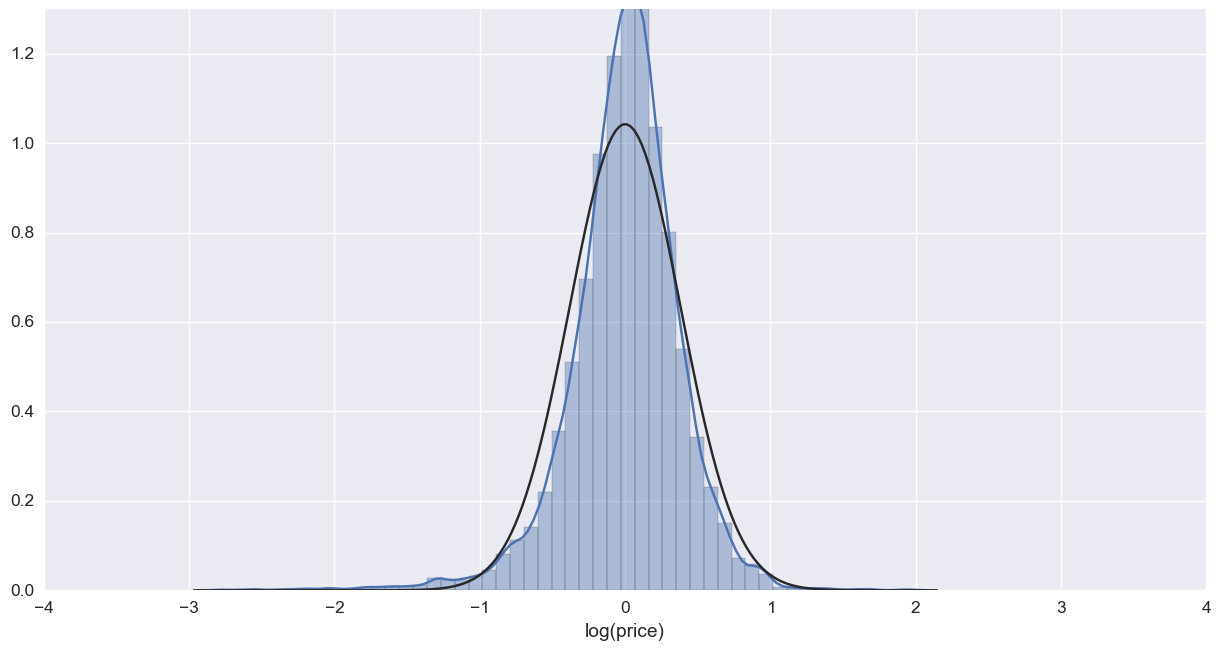

In [51]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 7.5)
ax.set_xlim([-4, 4])
ax.set_ylim([0, 1.3])
ax.set_xlabel("log(price)")
sns.distplot(pd.Series(results.predict(), index=airbnb_final.index) - airbnb_final["log(price)"], fit=norm)

In [52]:
airbnb_final_X = airbnb_final_X.drop(["minstay", "Low Price URAPlanningRegion"], axis=1)

# iv. Linear Regression (Comprehensive Analysis)

In [53]:
airbnb_final_X["overall_satisfaction*reviews"] = airbnb_final_X["overall_satisfaction"] * airbnb_final_X["reviews"]

In [54]:
airbnb_final_X_new = airbnb_final_X.copy()
airbnb_final_X_new["bedrooms*accommodates"] = airbnb_final_X_new["bedrooms"] * airbnb_final_X_new["accommodates"]
airbnb_final_X_new["log(train_dist)*log(bus_dist)"] = airbnb_final_X_new["log(train_dist)"] * airbnb_final_X_new["log(bus_dist)"]
airbnb_final_X_new["log(train_dist)*log(road_dist)"] = airbnb_final_X_new["log(train_dist)"] * airbnb_final_X_new["log(road_dist)"]
airbnb_final_X_new["log(bus_dist)*log(road_dist)"] = airbnb_final_X_new["log(bus_dist)"] * airbnb_final_X_new["log(road_dist)"]
airbnb_final_X_new["log(bus_dist)*log(road_dist)*log(train_dist)"] = airbnb_final_X_new["log(bus_dist)"] * airbnb_final_X_new["log(road_dist)"] * airbnb_final_X_new["log(train_dist)"]

In [55]:
internal_factors = ["accommodates", "bedrooms", "Entire home/apt", "Private room", "bedrooms*accommodates"]
external_factors = ["High Price Area", "Low Price Area", "log(train_dist)", "log(bus_dist)", "log(road_dist)", "log(train_dist)*log(bus_dist)", "log(train_dist)*log(road_dist)", "log(bus_dist)*log(road_dist)", "log(bus_dist)*log(road_dist)*log(train_dist)"]
sentiment_factors = ["overall_satisfaction", "overall_satisfaction*reviews"]

#  v. Distance Interaction

In [56]:
def get_model_and_plot(df_X, df_y):
    new_model = sm.OLS(df_y, sm.add_constant(df_X))
    results = new_model.fit()
    fig, ax = plt.subplots(2,1)
    fig.set_size_inches(15, 15)
    ax[0].set_xlim([-4, 4])
    ax[0].set_ylim([0, 1.3])
    ax[0].set_xlabel("log(price)")
    sns.distplot(pd.Series(results.predict(), index=df_y.index) - df_y, fit=norm, ax=ax[0])
    stats.probplot(pd.Series(results.predict(), index=df_y.index) - df_y, plot=ax[1])
    return results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log(price)   R-squared:                       0.699
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     1661.
Date:                Sun, 16 Apr 2017   Prob (F-statistic):               0.00
Time:                        22:12:37   Log-Likelihood:                -5523.9
No. Observations:               12150   AIC:                         1.108e+04
Df Residuals:                   12132   BIC:                         1.122e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
const                                            6.2929      0.833      7.558      0.000       4.661       7.925
reviews                                         -0.0005      0.000     -2.385      0.017      -0.001   -8.87e-05
overall_satisfaction                            -0.0124      0.002     -6.842      0.000      -0.016      -0.009
accommodates                                     0.0352      0.002     19.937      0.000       0.032       0.039
bedrooms                                         0.2270      0.006     41.256      0.000       0.216       0.238
log(train_dist)                                  0.5747      0.170      3.376      0.001       0.241       0.908
log(bus_dist)                                    0.5429      0.122      4.458      0.000       0.304       0.782
log(road_dist)                                   0.3989      0.122      3.281      0.001       0.161       0.637
log(AvgDistTouristAttraction)                   -0.1487      0.013    -11.622      0.000      -0.174      -0.124
Entire home/apt                                  1.4503      0.019     76.800      0.000       1.413       1.487
Private room                                     0.7877      0.019     41.088      0.000       0.750       0.825
High Price Neighborhood                          0.0695      0.010      7.131      0.000       0.050       0.089
Low Price Neighborhood                          -0.0535      0.011     -4.746      0.000      -0.076      -0.031
High Price URAPlanningRegion                     0.1251      0.011     11.899      0.000       0.104       0.146
log(train_dist)*log(bus_dist)                    0.0855      0.025      3.452      0.001       0.037       0.134
log(train_dist)*log(road_dist)                   0.0572      0.024      2.352      0.019       0.010       0.105
log(bus_dist)*log(road_dist)                     0.0496      0.017      2.853      0.004       0.016       0.084
log(bus_dist)*log(road_dist)*log(train_dist)     0.0073      0.003      2.112      0.035       0.001       0.014
==============================================================================
Omnibus:                     2393.890   Durbin-Watson:                   1.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11784.011
Skew:                           0.871   Prob(JB):                         0.00
Kurtosis:                       7.499   Cond. No.                     6.84e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.84e+04. This might indicate that there are
strong multicollinearity or other numerical problems.

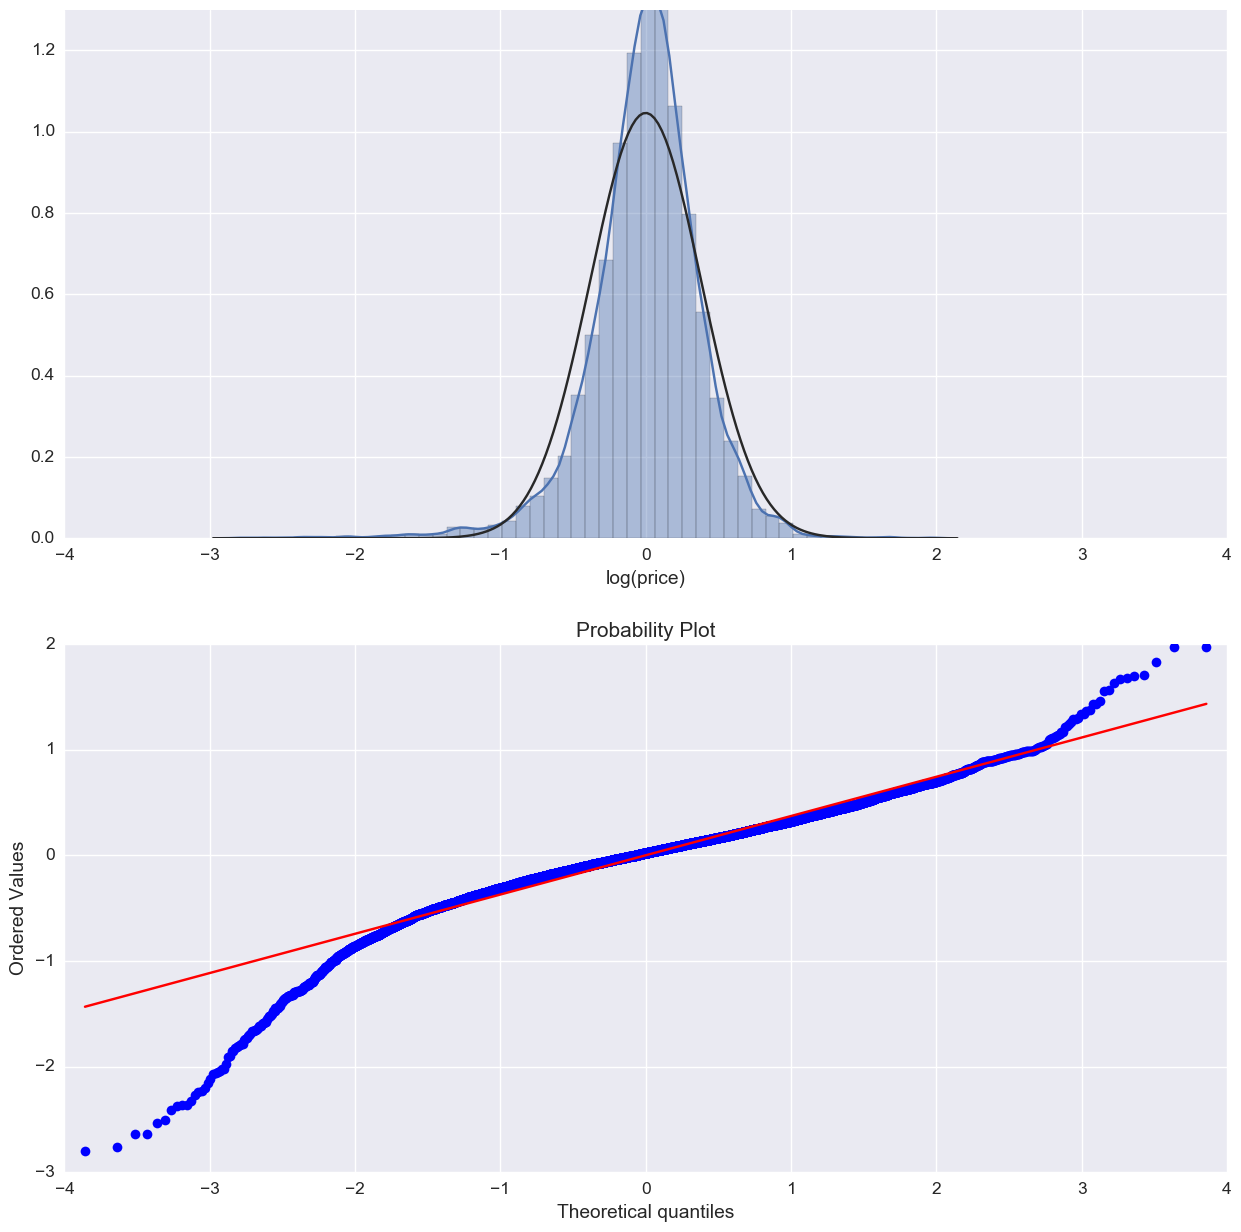

In [57]:
get_model_and_plot(airbnb_final_X_new.drop(["overall_satisfaction*reviews", "bedrooms*accommodates"], axis=1), airbnb_final_y)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log(price)   R-squared:                       0.699
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     2012.
Date:                Sun, 16 Apr 2017   Prob (F-statistic):               0.00
Time:                        22:12:38   Log-Likelihood:                -5533.7
No. Observations:               12150   AIC:                         1.110e+04
Df Residuals:                   12135   BIC:                         1.121e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
const                                            3.6555      0.153     23.827      0.000       3.355       3.956
reviews                                         -0.0005      0.000     -2.491      0.013      -0.001      -0.000
overall_satisfaction                            -0.0125      0.002     -6.871      0.000      -0.016      -0.009
accommodates                                     0.0353      0.002     19.984      0.000       0.032       0.039
bedrooms                                         0.2263      0.006     41.140      0.000       0.216       0.237
log(train_dist)                                  0.0570      0.015      3.778      0.000       0.027       0.087
log(bus_dist)                                    0.1061      0.012      9.027      0.000       0.083       0.129
log(road_dist)                                   0.1048      0.011      9.753      0.000       0.084       0.126
log(AvgDistTouristAttraction)                   -0.1500      0.013    -11.736      0.000      -0.175      -0.125
Entire home/apt                                  1.4493      0.019     76.726      0.000       1.412       1.486
Private room                                     0.7863      0.019     41.003      0.000       0.749       0.824
High Price Neighborhood                          0.0727      0.010      7.473      0.000       0.054       0.092
Low Price Neighborhood                          -0.0544      0.011     -4.823      0.000      -0.076      -0.032
High Price URAPlanningRegion                     0.1235      0.011     11.754      0.000       0.103       0.144
log(bus_dist)*log(road_dist)*log(train_dist)    -0.0023      0.000     -7.981      0.000      -0.003      -0.002
==============================================================================
Omnibus:                     2414.702   Durbin-Watson:                   1.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11885.566
Skew:                           0.879   Prob(JB):                         0.00
Kurtosis:                       7.515   Cond. No.                     1.18e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.18e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

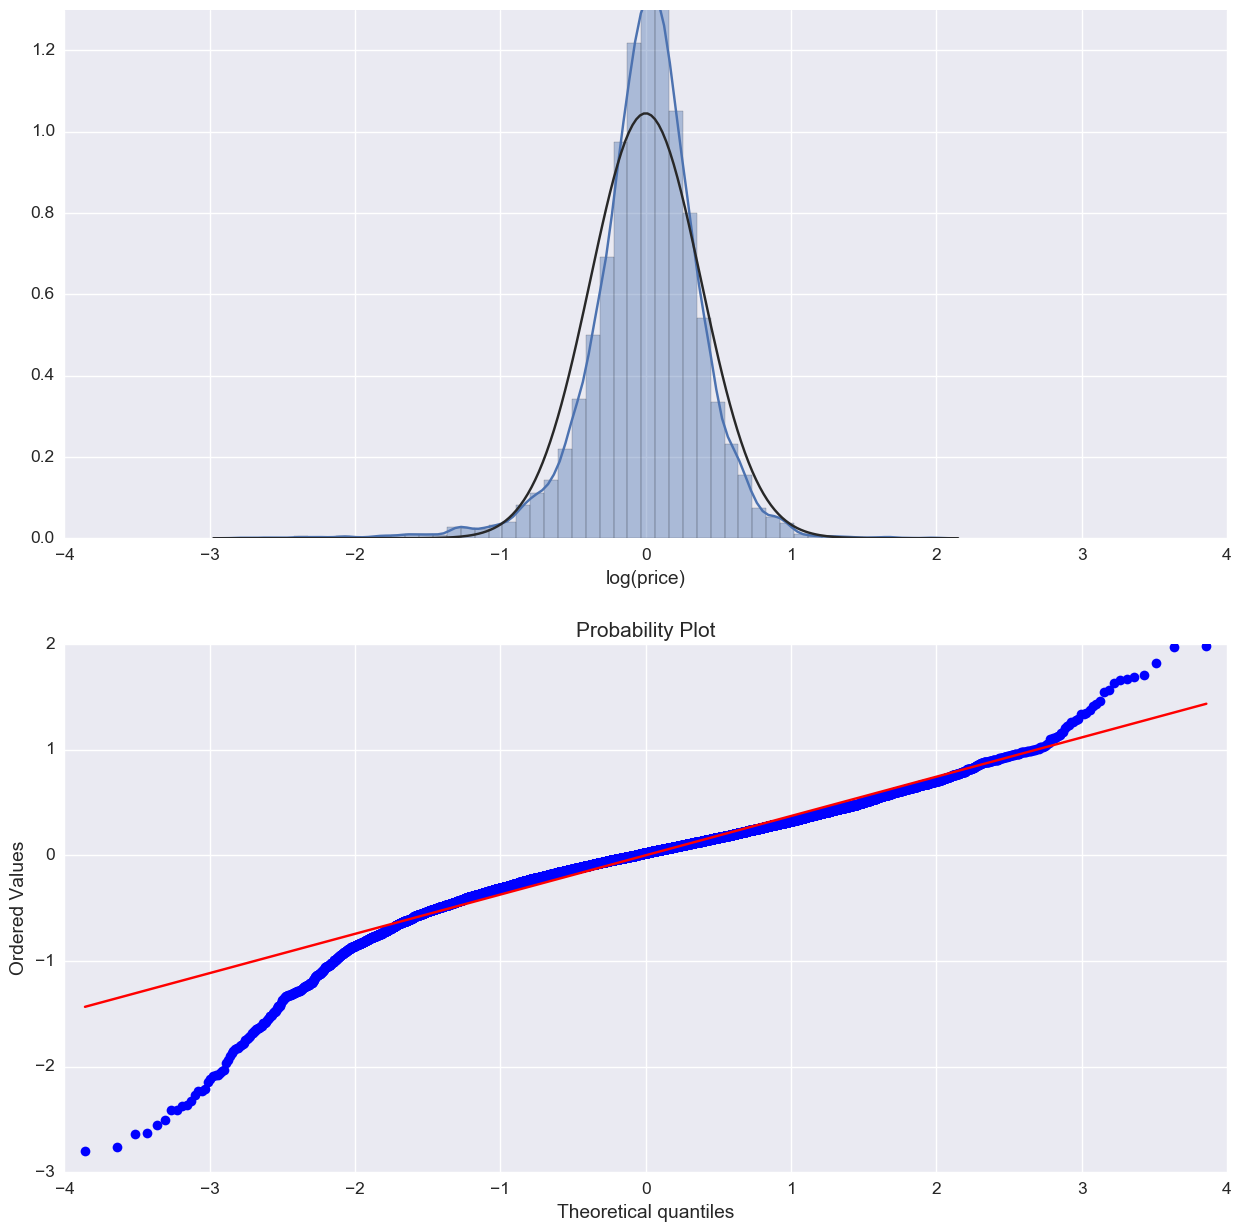

In [58]:
get_model_and_plot(airbnb_final_X_new.drop(["overall_satisfaction*reviews", "bedrooms*accommodates", "log(train_dist)*log(bus_dist)", "log(train_dist)*log(road_dist)", "log(bus_dist)*log(road_dist)"], axis=1), airbnb_final_y)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log(price)   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.698
Method:                 Least Squares   F-statistic:                     2007.
Date:                Sun, 16 Apr 2017   Prob (F-statistic):               0.00
Time:                        22:12:39   Log-Likelihood:                -5544.3
No. Observations:               12150   AIC:                         1.112e+04
Df Residuals:                   12135   BIC:                         1.123e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             3.4676      0.157     22.120      0.000       3.160       3.775
reviews                          -0.0005      0.000     -2.388      0.017      -0.001   -8.96e-05
overall_satisfaction             -0.0125      0.002     -6.846      0.000      -0.016      -0.009
accommodates                      0.0350      0.002     19.788      0.000       0.031       0.038
bedrooms                          0.2285      0.005     41.604      0.000       0.218       0.239
log(train_dist)                  -0.0574      0.005    -10.770      0.000      -0.068      -0.047
log(bus_dist)                     0.1646      0.022      7.341      0.000       0.121       0.208
log(road_dist)                    0.1582      0.021      7.506      0.000       0.117       0.200
log(AvgDistTouristAttraction)    -0.1452      0.013    -11.354      0.000      -0.170      -0.120
Entire home/apt                   1.4485      0.019     76.618      0.000       1.411       1.486
Private room                      0.7862      0.019     40.963      0.000       0.749       0.824
High Price Neighborhood           0.0718      0.010      7.375      0.000       0.053       0.091
Low Price Neighborhood           -0.0532      0.011     -4.710      0.000      -0.075      -0.031
High Price URAPlanningRegion      0.1232      0.011     11.717      0.000       0.103       0.144
log(bus_dist)*log(road_dist)      0.0199      0.003      6.518      0.000       0.014       0.026
==============================================================================
Omnibus:                     2407.333   Durbin-Watson:                   1.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11753.115
Skew:                           0.879   Prob(JB):                         0.00
Kurtosis:                       7.487   Cond. No.                     2.41e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.41e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

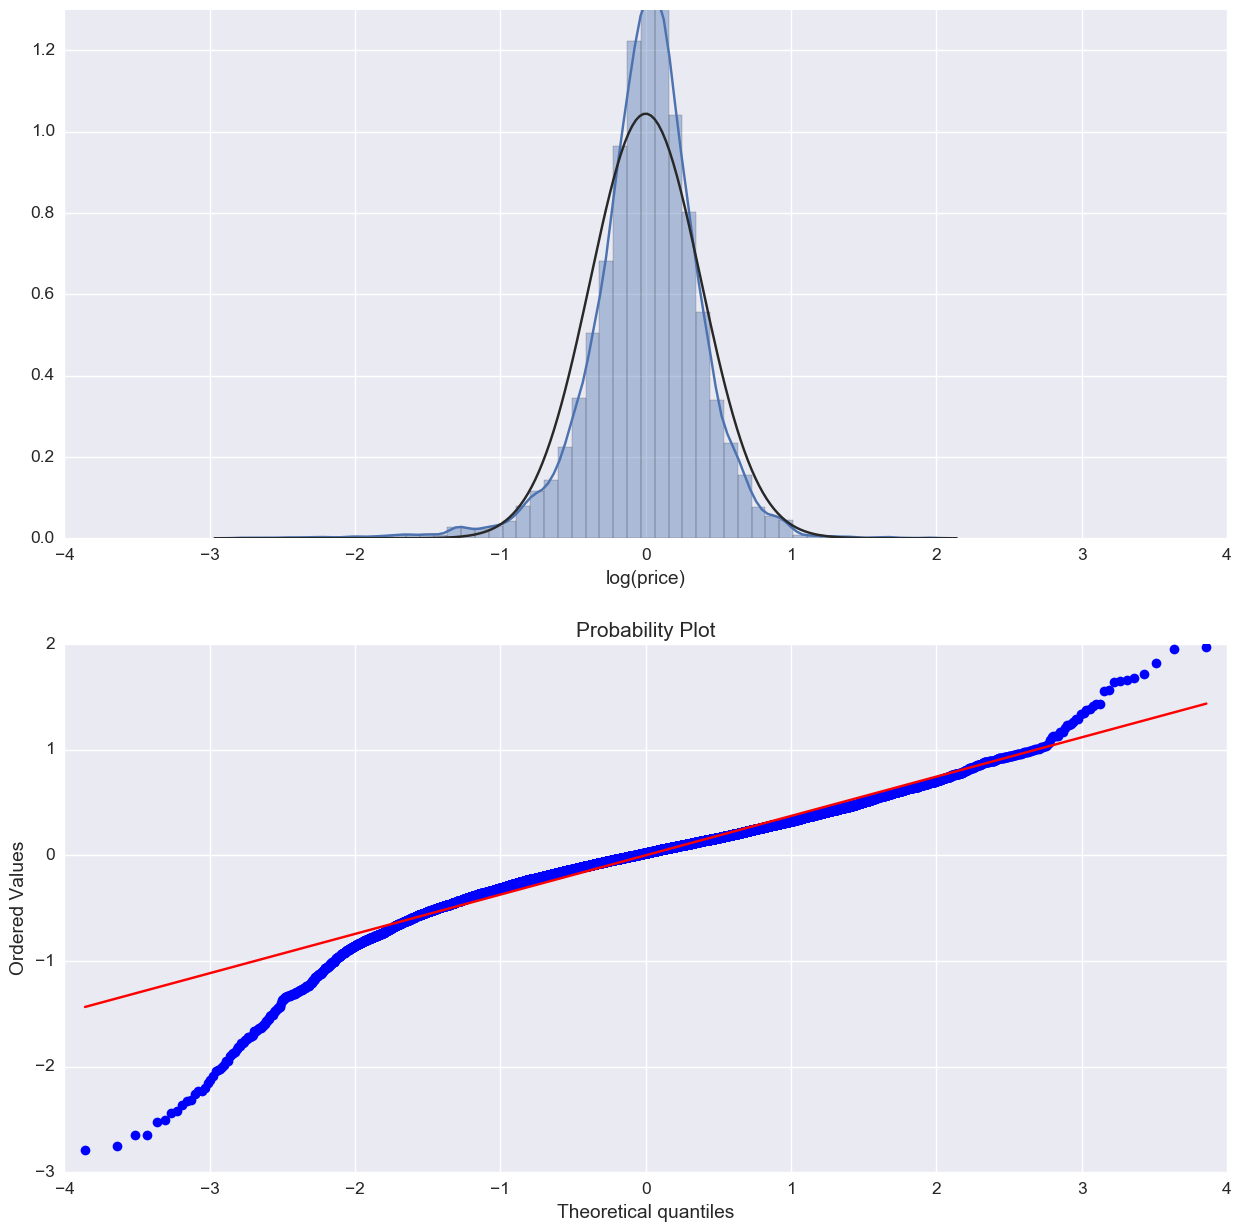

In [59]:
get_model_and_plot(airbnb_final_X_new.drop(["overall_satisfaction*reviews", "bedrooms*accommodates", "log(train_dist)*log(bus_dist)", "log(train_dist)*log(road_dist)", "log(bus_dist)*log(road_dist)*log(train_dist)"], axis=1), airbnb_final_y)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log(price)   R-squared:                       0.699
Model:                            OLS   Adj. R-squared:                  0.698
Method:                 Least Squares   F-statistic:                     2011.
Date:                Sun, 16 Apr 2017   Prob (F-statistic):               0.00
Time:                        22:12:40   Log-Likelihood:                -5537.4
No. Observations:               12150   AIC:                         1.110e+04
Df Residuals:                   12135   BIC:                         1.122e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             4.1841      0.230     18.188      0.000       3.733       4.635
reviews                          -0.0005      0.000     -2.393      0.017      -0.001   -9.05e-05
overall_satisfaction             -0.0124      0.002     -6.831      0.000      -0.016      -0.009
accommodates                      0.0351      0.002     19.898      0.000       0.032       0.039
bedrooms                          0.2283      0.005     41.591      0.000       0.218       0.239
log(train_dist)                   0.2759      0.045      6.194      0.000       0.189       0.363
log(bus_dist)                     0.2711      0.034      8.077      0.000       0.205       0.337
log(road_dist)                    0.0229      0.003      8.066      0.000       0.017       0.028
log(AvgDistTouristAttraction)    -0.1486      0.013    -11.628      0.000      -0.174      -0.124
Entire home/apt                   1.4496      0.019     76.717      0.000       1.413       1.487
Private room                      0.7884      0.019     41.102      0.000       0.751       0.826
High Price Neighborhood           0.0688      0.010      7.061      0.000       0.050       0.088
Low Price Neighborhood           -0.0547      0.011     -4.851      0.000      -0.077      -0.033
High Price URAPlanningRegion      0.1266      0.011     12.040      0.000       0.106       0.147
log(train_dist)*log(bus_dist)     0.0490      0.007      7.497      0.000       0.036       0.062
==============================================================================
Omnibus:                     2419.029   Durbin-Watson:                   1.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12083.153
Skew:                           0.876   Prob(JB):                         0.00
Kurtosis:                       7.560   Cond. No.                     2.74e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.74e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

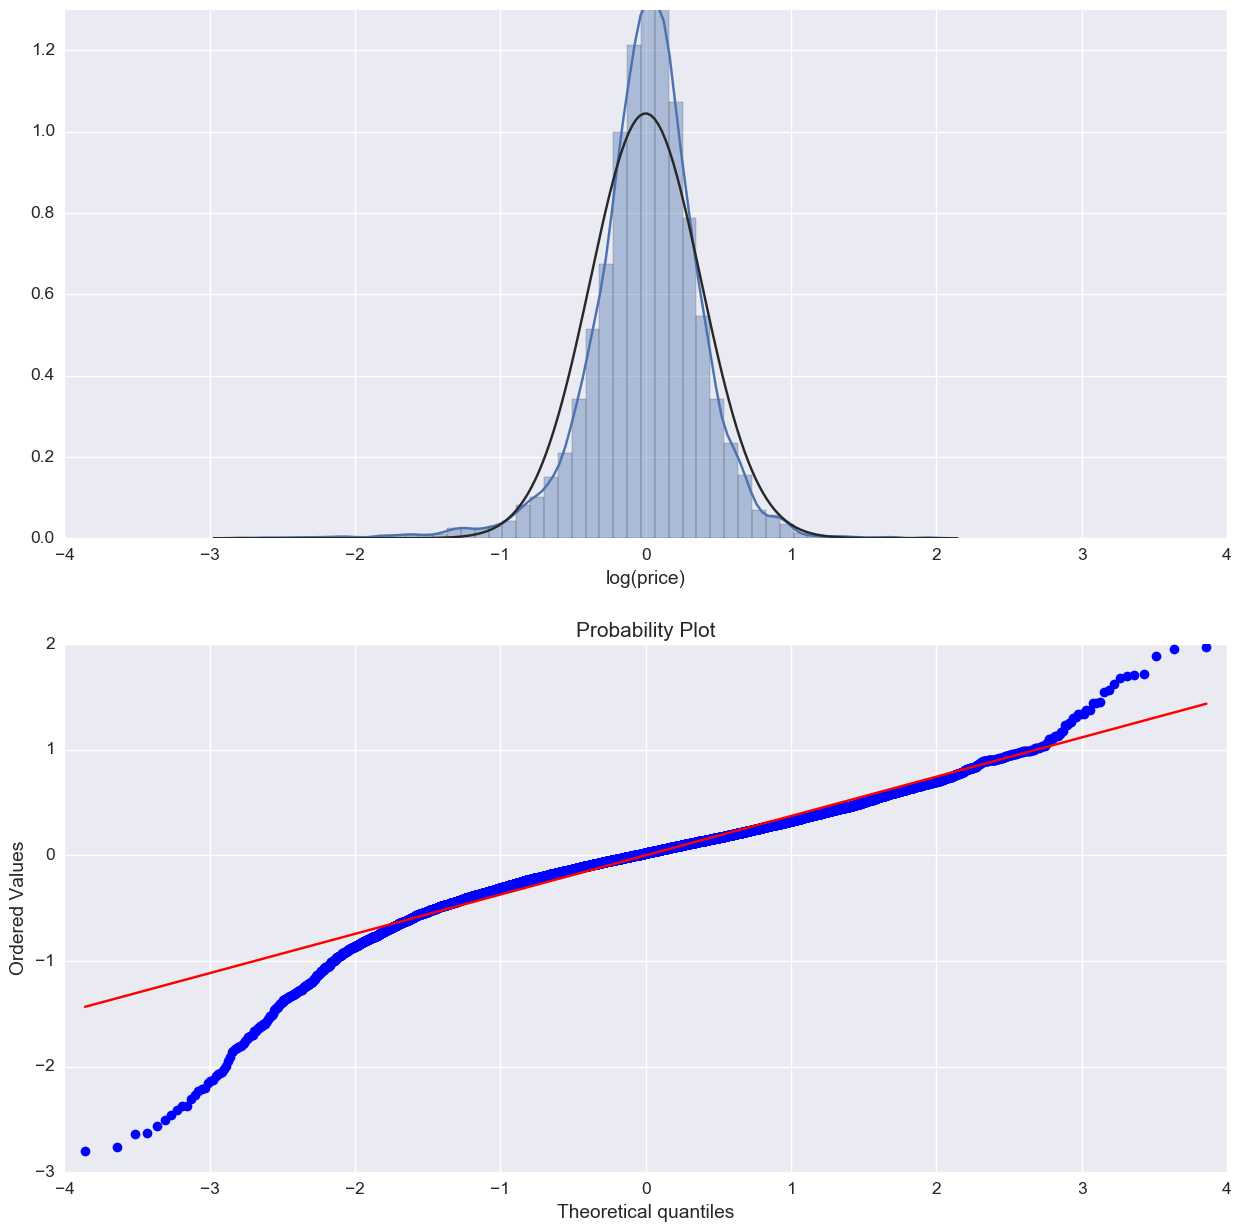

In [60]:
get_model_and_plot(airbnb_final_X_new.drop(["overall_satisfaction*reviews", "bedrooms*accommodates", "log(train_dist)*log(road_dist)", "log(bus_dist)*log(road_dist)", "log(bus_dist)*log(road_dist)*log(train_dist)"], axis=1), airbnb_final_y)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log(price)   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.698
Method:                 Least Squares   F-statistic:                     2003.
Date:                Sun, 16 Apr 2017   Prob (F-statistic):               0.00
Time:                        22:12:41   Log-Likelihood:                -5553.9
No. Observations:               12150   AIC:                         1.114e+04
Df Residuals:                   12135   BIC:                         1.125e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                              3.1066      0.136     22.898      0.000       2.841       3.373
reviews                           -0.0005      0.000     -2.529      0.011      -0.001      -0.000
overall_satisfaction              -0.0125      0.002     -6.851      0.000      -0.016      -0.009
accommodates                       0.0353      0.002     19.974      0.000       0.032       0.039
bedrooms                           0.2273      0.006     41.206      0.000       0.216       0.238
log(train_dist)                    0.0623      0.025      2.483      0.013       0.013       0.111
log(bus_dist)                      0.0222      0.005      4.107      0.000       0.012       0.033
log(road_dist)                     0.1070      0.018      5.985      0.000       0.072       0.142
log(AvgDistTouristAttraction)     -0.1501      0.013    -11.708      0.000      -0.175      -0.125
Entire home/apt                    1.4500      0.019     76.633      0.000       1.413       1.487
Private room                       0.7880      0.019     41.026      0.000       0.750       0.826
High Price Neighborhood            0.0739      0.010      7.584      0.000       0.055       0.093
Low Price Neighborhood            -0.0547      0.011     -4.842      0.000      -0.077      -0.033
High Price URAPlanningRegion       0.1231      0.011     11.691      0.000       0.102       0.144
log(train_dist)*log(road_dist)     0.0163      0.003      4.811      0.000       0.010       0.023
==============================================================================
Omnibus:                     2439.095   Durbin-Watson:                   1.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12080.992
Skew:                           0.887   Prob(JB):                         0.00
Kurtosis:                       7.552   Cond. No.                     1.71e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.71e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

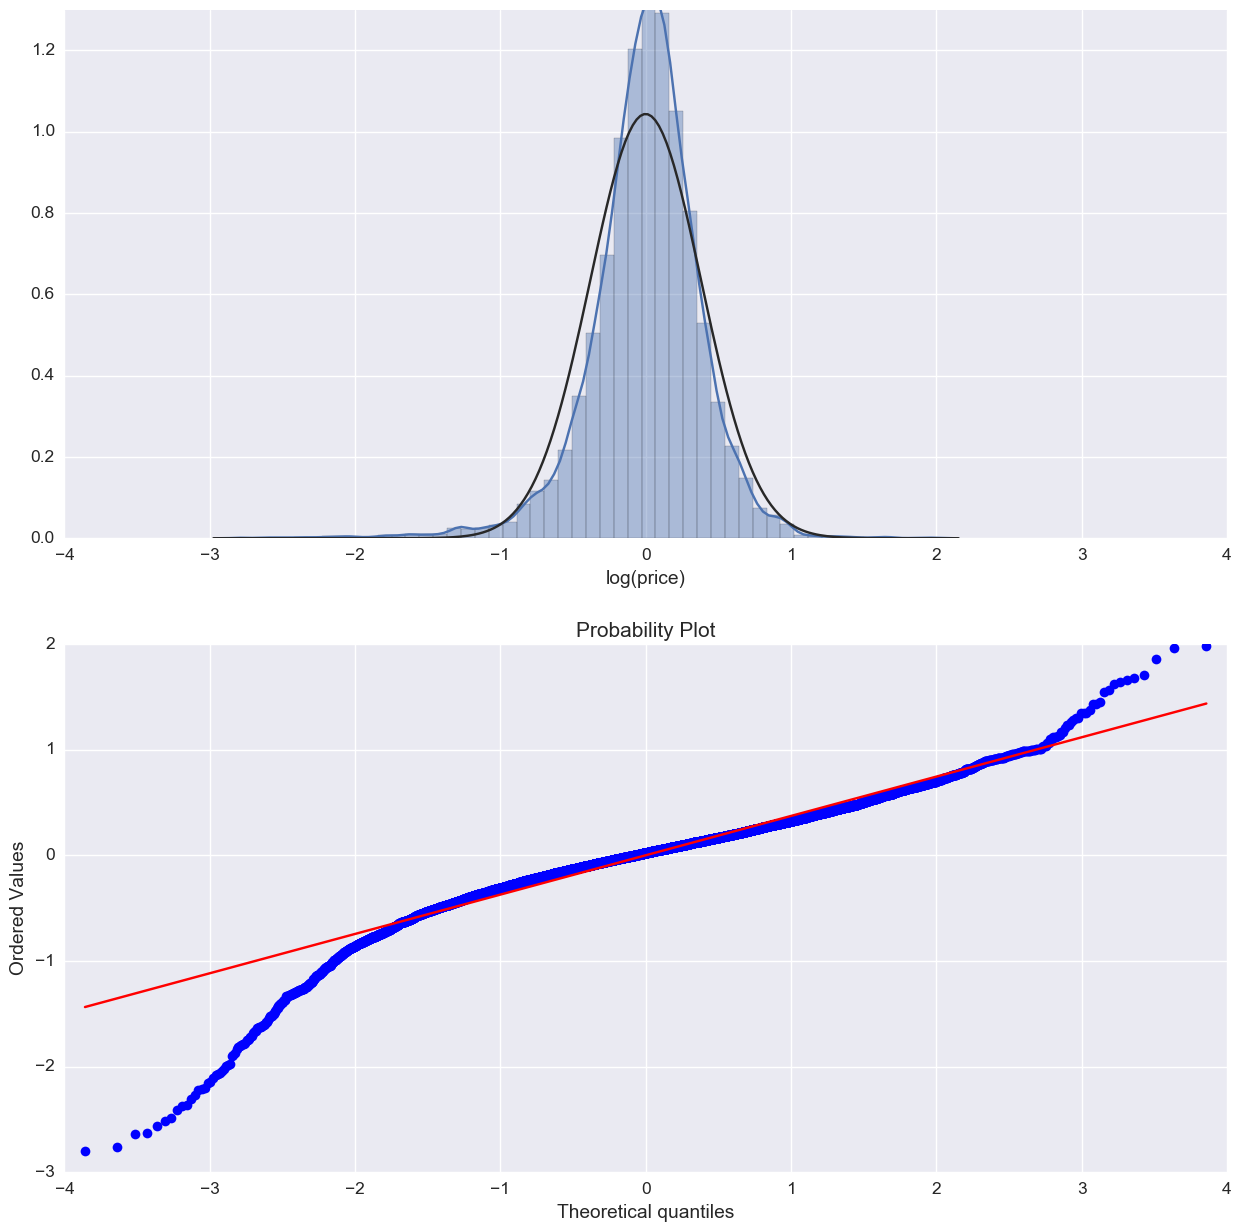

In [61]:
get_model_and_plot(airbnb_final_X_new.drop(["overall_satisfaction*reviews", "bedrooms*accommodates", "log(train_dist)*log(bus_dist)", "log(bus_dist)*log(road_dist)", "log(bus_dist)*log(road_dist)*log(train_dist)"], axis=1), airbnb_final_y)